# Testing Mitiq ZNE in OpenQAOA

## 1. Creation of the graph + QUBO model

In [1]:
from openqaoa.problems.maximumcut import MaximumCut

In [7]:
def create_graph(nodes,edges):
    graph = nx.Graph()
    graph.add_nodes_from(nodes)
    graph.add_edges_from(edges)
    nx.draw(graph, with_labels=True, alpha=0.8, node_size=500)
    return graph

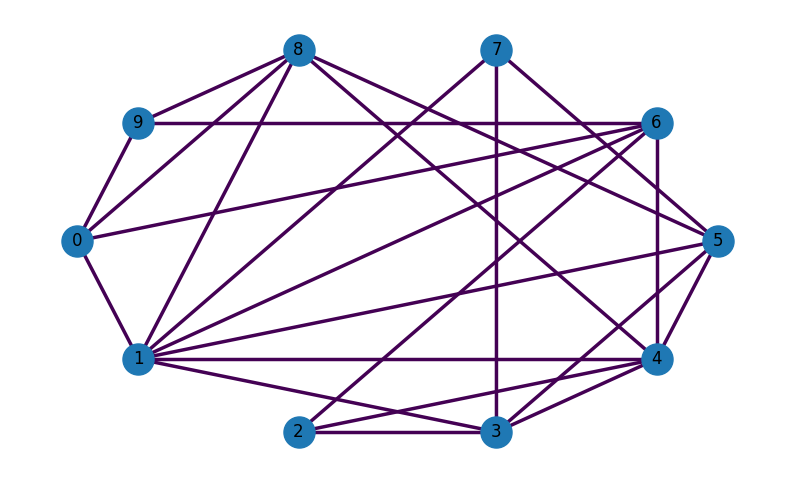

In [2]:
import networkx as nx
from openqaoa.problems import MaximumCut
from openqaoa.utilities import plot_graph
""" G = create_graph(
[0, 1, 2, 3, 4, ],
[(0, 1), (0, 2), (0, 3), (0, 4), (1, 2), (2, 3), (3, 4)] 
) """

#Inner OpenQAOA function for ploting graphs
#plot_graph(graph)

# Create a MaximumCut instance from the graph and get its QUBO and hamiltonian
#maxcut_prob = MaximumCut(G)
maxcut_prob = MaximumCut.random_instance(n_nodes = 10, edge_probability = 0.5)
plot_graph(maxcut_prob.G)
maxcut_qubo = maxcut_prob.qubo
maxcut_hamiltonian = maxcut_qubo.hamiltonian

## 2.  OpenQAOA  

### 2.1. Configuration, compilation and optimization

In [3]:
from tqdm import tqdm

In [14]:
ps = [1, 2, 3, 4, 5, 6]
param_types = [ "extended"]
init_types = ["rand", "ramp"]
mixer_hams = ["x", "xy"]
optimizers = ["Nelder-Mead", "Powell", "COBYLA"]
for p in tqdm(ps):
    for param_type in tqdm(param_types):
        for init_type in tqdm(init_types):
            for mixer_hamiltonian in tqdm(mixer_hams):
                for optimizer in tqdm(optimizers):
                    print("params = %s-%s-%s-%s-%s" % (str(p), str(param_type), str(init_type), str(mixer_hamiltonian), str(optimizer)))
                    q1 = QAOA()
                    qiskit_device = create_device(location='local', name='qiskit.shot_simulator')
                    q1.set_device(qiskit_device)
                    q1.set_circuit_properties(p=p, param_type=param_type, init_type=init_type, mixer_hamiltonian=mixer_hamiltonian)
                    q1.set_backend_properties(n_shots=10000, seed_simulator=1)
                    q1.set_classical_optimizer(method=optimizer, maxiter=200, tol=0.001,
                    optimization_progress=True, cost_progress=True, parameter_log=True)
                    q1.compile(maxcut_qubo)
                    q1.optimize()
                    correct_solution1 = ground_state_hamiltonian(q1.cost_hamil)
                    print(correct_solution1)
                    opt_results1 = q1.result
                    noise_model = add_depolarizing_error(NoiseModel(),0.1)
                    q2 = QAOA()
                    qiskit_device = create_device(location='local', name='qiskit.shot_simulator')
                    q2.set_device(qiskit_device)
                    q2.set_circuit_properties(p=p, param_type=param_type, init_type=init_type, mixer_hamiltonian=mixer_hamiltonian)
                    q2.set_classical_optimizer(method=optimizer, maxiter=200, tol=0.001,
                                            optimization_progress=True, cost_progress=True, parameter_log=True)
                    q2.set_backend_properties(n_shots=5000, seed_simulator=1,
                                            noise_model=noise_model)
                    q2.compile(maxcut_qubo)
                    q2.optimize()
                    correct_solution2 = ground_state_hamiltonian(q2.cost_hamil)
                    opt_results2 = q2.result
                    print(correct_solution2)
                    qiskit_device = create_device(location='local', name='qiskit.shot_simulator')
                    q3 = QAOA()
                    q3.set_device(qiskit_device)
                    q3.set_circuit_properties(p=p, param_type=param_type, init_type=init_type, mixer_hamiltonian=mixer_hamiltonian)
                    q3.set_classical_optimizer(method=optimizer, maxiter=200, tol=0.001,
                                            optimization_progress=True, cost_progress=True, parameter_log=True)
                    q3.set_backend_properties(n_shots=5000, seed_simulator=1, noise_model=noise_model)
                    q3.set_error_mitigation_properties(error_mitigation_technique='mitiq_zne',n_batches=64,calibration_data_location="caldata.json")
                    q3.compile(maxcut_qubo)
                    q3.optimize()
                    correct_solution3 = ground_state_hamiltonian(q3.cost_hamil)
                    print(correct_solution3)
                    opt_results3 = q3.result

                    #plot_cost(opt_results2,)

                    fig, ax = plt.subplots(figsize=(7,4))
                    opt_results1.plot_cost(figsize=(7,4),color='blue',label='qaoa',ax=ax)
                    opt_results2.plot_cost(figsize=(7,4),color='red',label='qaoa+noise',ax=ax)
                    opt_results3.plot_cost(figsize=(7,4),color='green',label='qaoa+noise+zne',ax=ax)
                    plt.savefig("%s-%s-%s-%s-%s-1.png" % (str(p), str(param_type), str(init_type), str(mixer_hamiltonian), str(optimizer)))
                    fig2, ax2 = plt.subplots(figsize=(7,4))
                    opt_results2.plot_cost(figsize=(7,4),color='red',label='qaoa+noise',ax=ax2)
                    opt_results3.plot_cost(figsize=(7,4),color='green',label='qaoa+noise+zne',ax=ax2)
                    plt.savefig("%s-%s-%s-%s-%s-2.png" % (str(p), str(param_type), str(init_type), str(mixer_hamiltonian), str(optimizer)))

  0%|          | 0/6 [00:00<?, ?it/s]







params = 1-extended-rand-x-Nelder-Mead
(-9.0, ['0101001010', '0001011010', '1001011010', '0001001110', '1001001110', '0001101110', '1001101110', '0110010001', '1110010001', '0110110001', '1110110001', '0110100101', '1110100101', '1010110101'])
(-9.0, ['0101001010', '0001011010', '1001011010', '0001001110', '1001001110', '0001101110', '1001101110', '0110010001', '1110010001', '0110110001', '1110110001', '0110100101', '1110100101', '1010110101'])
(-9.0, ['0101001010', '0001011010', '1001011010', '0001001110', '1001001110', '0001101110', '1001101110', '0110010001', '1110010001', '0110110001', '1110110001', '0110100101', '1110100101', '1010110101'])


params = 1-extended-rand-x-Powell
(-9.0, ['0101001010', '0001011010', '1001011010', '0001001110', '1001001110', '0001101110', '1001101110', '0110010001', '1110010001', '0110110001', '1110110001', '0110100101', '1110100101', '1010110101'])
(-9.0, ['0101001010', '0001011010', '1001011010', '0001001110', '1001001110', '0001101110', '1001101110', '0110010001', '1110010001', '0110110001', '1110110001', '0110100101', '1110100101', '1010110101'])


In [6]:
from openqaoa import QAOA  
q1 = QAOA()
q1

In [7]:
from openqaoa.backends import create_device
qiskit_device = create_device(location='local', name='qiskit.shot_simulator')
q1.set_device(qiskit_device)
q1.set_circuit_properties(p=3,param_type='standard', init_type='rand', mixer_hamiltonian='x')
q1.set_backend_properties(n_shots=10000, seed_simulator=1)
q1.set_classical_optimizer(method='nelder-mead', maxiter=200, tol=0.001,
                          optimization_progress=True, cost_progress=True, parameter_log=True)

In [9]:
q1.compile(maxcut_qubo)

In [10]:
q1.optimize()

### 2.2. Results

In [8]:
from openqaoa.utilities import ground_state_hamiltonian
correct_solution1 = ground_state_hamiltonian(q1.cost_hamil)
print(correct_solution1)

opt_results1 = q1.result
opt_results1.plot_cost(figsize=(7,4),label='qaoa')

AttributeError: 'QAOA' object has no attribute 'cost_hamil'

## 3. OpenQAOA + noise

### 3.1 Adding a noise model

In [12]:
from qiskit_aer.noise import (NoiseModel, depolarizing_error)

one_qubit_gates = ['h','rx']
two_qubits_gates = ['rzz']

#create depol. noise
def add_depolarizing_error(noise_model,prob):
    noise_model = add_one_qubit_depolarizing_error(noise_model,prob)
    noise_model = add_two_qubits_depolarizing_error(noise_model,prob)
    return noise_model

#create 1 qubit depol. noise
def add_one_qubit_depolarizing_error(noise_model,prob):
    error = depolarizing_error(prob, 1)
    noise_model.add_all_qubit_quantum_error(error,one_qubit_gates)
    return noise_model

#create 2 qubits depol.noise
def add_two_qubits_depolarizing_error(noise_model,prob):
    error = depolarizing_error(prob, 2)
    noise_model.add_all_qubit_quantum_error(error, two_qubits_gates)
    return noise_model

noise_model = add_depolarizing_error(NoiseModel(),0.1)

### 2.2. Configuration, compilation and optimization

In [14]:
from openqaoa import QAOA  
q2 = QAOA()
q2

In [15]:
from openqaoa.backends import create_device

qiskit_device = create_device(location='local', name='qiskit.shot_simulator')
q2.set_device(qiskit_device)
q2.set_circuit_properties(p=3,param_type='standard', init_type='rand', mixer_hamiltonian='x')
q2.set_classical_optimizer(method='nelder-mead', maxiter=200, tol=0.001,
                          optimization_progress=True, cost_progress=True, parameter_log=True)
q2.set_backend_properties(n_shots=5000, seed_simulator=1,
                          noise_model=noise_model)

In [16]:
q2.compile(maxcut_qubo)

In [17]:
q2.optimize()

### 2.3 Results

(-11.0, ['0100110110', '1011001001'])


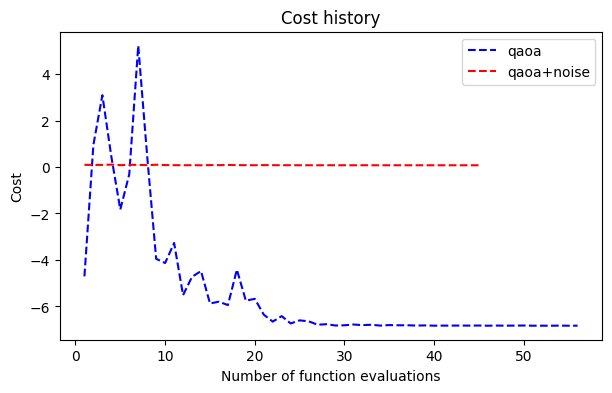

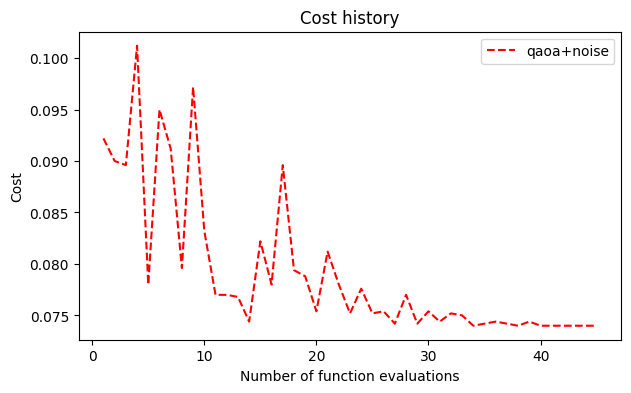

In [18]:
from openqaoa.utilities import ground_state_hamiltonian
import matplotlib.pyplot as plt
correct_solution2 = ground_state_hamiltonian(q2.cost_hamil)
print(correct_solution2)

opt_results2 = q2.result

#plot_cost(opt_results2,)

fig, ax = plt.subplots(figsize=(7,4))
opt_results1.plot_cost(color='blue',label='qaoa',ax=ax)
opt_results2.plot_cost(color='red',label='qaoa+noise',ax=ax)
opt_results2.plot_cost(figsize=(7,4),color='red',label='qaoa+noise')


## 4. OpenQAOA + noise + ZNE

### 4.1. Configuration

In [19]:
from openqaoa import QAOA  
q3 = QAOA()
q3

In [20]:
from openqaoa.backends import create_device

qiskit_device = create_device(location='local', name='qiskit.shot_simulator')
q3.set_device(qiskit_device)
q3.set_circuit_properties(p=3,param_type='standard', init_type='rand', mixer_hamiltonian='x')
q3.set_classical_optimizer(method='nelder-mead', maxiter=200, tol=0.001,
                          optimization_progress=True, cost_progress=True, parameter_log=True)
q3.set_backend_properties(n_shots=5000, seed_simulator=1,
                          noise_model=noise_model
                         )

### 4.2. Adding ZNE technique

In [21]:
q3.set_error_mitigation_properties(
    error_mitigation_technique='mitiq_zne',n_batches=4,calibration_data_location="caldata.json"
)

### 4.3. compilation and optimization

In [22]:
q3.compile(maxcut_qubo)

In [23]:
q3.optimize()

### 4.4 Results

In [13]:
from openqaoa.utilities import ground_state_hamiltonian
import matplotlib.pyplot as plt
correct_solution3 = ground_state_hamiltonian(q3.cost_hamil)
print(correct_solution3)

opt_results3 = q3.result

#plot_cost(opt_results2,)

fig, ax = plt.subplots(figsize=(7,4))
opt_results1.plot_cost(figsize=(7,4),color='blue',label='qaoa',ax=ax)
opt_results2.plot_cost(figsize=(7,4),color='red',label='qaoa+noise',ax=ax)
opt_results3.plot_cost(figsize=(7,4),color='green',label='qaoa+noise+zne',ax=ax)

fig2, ax2 = plt.subplots(figsize=(7,4))
opt_results2.plot_cost(figsize=(7,4),color='red',label='qaoa+noise',ax=ax2)
opt_results3.plot_cost(figsize=(7,4),color='green',label='qaoa+noise+zne',ax=ax2)


NameError: name 'q3' is not defined

## 5. Variable depolarizing noise over OpenQAOA, OpenQAOA+noise and OpenQAOA+noise+zne

In [193]:
noise_probs = range(0,50,5)
for i in noise

5


## Requesting Mitiq ZNE mitigation and compiling

In [13]:
q.set_error_mitigation_properties(
    error_mitigation_technique='mitiq_zne',n_batches=4,calibration_data_location="caldata.json"
)
q.set_circuit_properties(p=2)
q.set_backend_properties(n_shots=10000, seed_simulator=1, noise_model = noise_model)

q.compile(maxcut_qubo)

## Optimization

In [14]:
q.optimize()

## Getting the solution

In [15]:
from openqaoa.utilities import ground_state_hamiltonian
correct_solution = ground_state_hamiltonian(q.cost_hamil)
correct_solution

(-3.0,
 ['10100', '10010', '01010', '11010', '00101', '10101', '01101', '01011'])

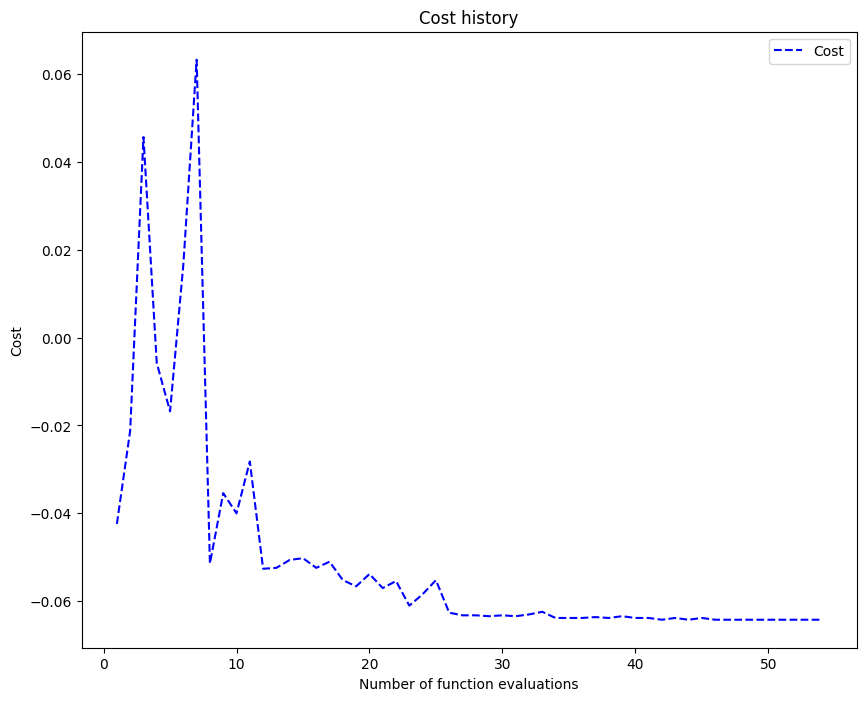

In [16]:
opt_results = q.result
opt_results.plot_cost()


## Comparing with standard QAOA, with noise

In [30]:
q1 = QAOA()
q1.set_device(qiskit_device)

noise_model = add_depolarizing_error(NoiseModel(),0.3)
q1.set_circuit_properties(p=2)
q1.set_backend_properties(n_shots=10000, seed_simulator=1, noise_model = noise_model)

""" q1.set_backend_properties(n_shots=1024, seed_simulator=1, noise_model = noise_model) """

q1.compile(maxcut_qubo)

In [31]:
q1.optimize()

In [32]:
correct_solution = ground_state_hamiltonian(q1.cost_hamil)
correct_solution

(-3.0,
 ['10100', '10010', '01010', '11010', '00101', '10101', '01101', '01011'])

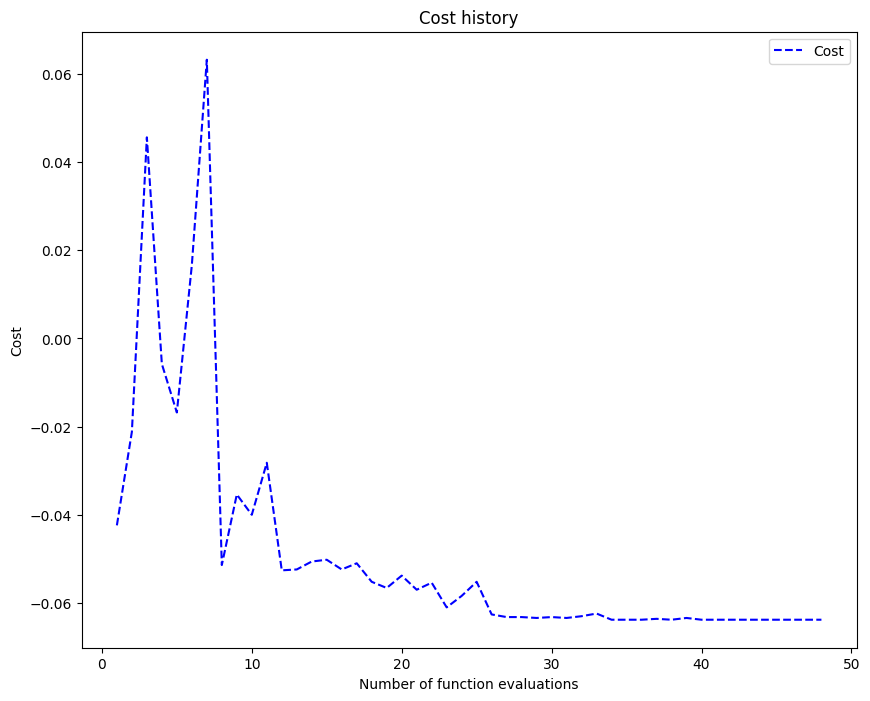

In [33]:
opt_results = q1.result
opt_results.plot_cost()

## Comparing with standard QAOA, with IBM Quantum backend

In [5]:
from qiskit import IBMQ
from openqaoa import create_device
from qiskit_ibm_provider import IBMProvider

In [36]:
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [13]:
ibm_device = create_device(location='ibmq', 
                                name='ibm_osaka',
                                hub='ibm-q', 
                                group='open', 
                                project='main')

In [14]:
q2 = QAOA()
q2.set_device(ibm_device)
q2.compile(maxcut_qubo)

In [15]:
q2.optimize()

KeyboardInterrupt: 

In [ ]:
correct_solution = ground_state_hamiltonian(q2.cost_hamil)
correct_solution

## Comparing with OpenQAOA + Mitiq ZNE, with IBM Quantum backend

In [7]:
q3 = QAOA()
q3.set_device(ibm_device)
q3.set_backend_properties(n_shots=1024, seed_simulator=1)
q3.set_error_mitigation_properties(
    error_mitigation_technique='mitiq_zne',n_batches=4,calibration_data_location="caldata.json"
)
q3.compile(maxcut_qubo)

In [8]:
q3.optimize()

TranspilerError: "The number of qubits for Instruction(name='cz', num_qubits=2, num_clbits=0, params=[]) does not match the number of qubits in the properties dictionary: (0,)"

In [ ]:
correct_solution = ground_state_hamiltonian(q3.cost_hamil)
correct_solution

In [8]:
from openqaoa.backends.qaoa_backend import (
    DEVICE_NAME_TO_OBJECT_MAPPER,
    DEVICE_ACCESS_OBJECT_MAPPER,
)

In [9]:
print(DEVICE_NAME_TO_OBJECT_MAPPER.keys())

dict_keys(['vectorized', 'analytical_simulator', 'qiskit.qasm_simulator', 'qiskit.shot_simulator', 'qiskit.statevector_simulator'])
